Adjusted search removing source bias

This work borrows heavily from the code base at: https://github.com/ccatalao/covid19vaccine-emotions/blob/master/olstorm.ipynb

In [1]:
import tweepy
import snscrape.modules.twitter as sntwitter
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import ssl

In [2]:
search_df = pd.read_csv('search_data.csv')
search_df.head()

,project,start,five_year_mark,end_date,handle,country
0,Konza tech,2013-01-01,2016-01-01,2020-12-31,konzatech,Kenya
1,Eko Atlantic,2009-01-01,2016-01-01,2020-12-31,EkoAtlantic,Nigeria
2,Waterfall City,2006-01-01,2016-01-01,2020-12-31,WaterfallCityZA,South Africa
3,Hope city,2013-01-01,2016-01-01,2020-12-31,NaN,Ghana
4,Vision city,2013-01-01,2016-01-01,2020-12-31,thevisioncity,Rwanda


In [3]:
# Code adapted from https://medium.datadriveninvestor.com/how-to-build-a-twitter-scraping-app-with-python-b3fc069a19c6
def create_data_file(idx, last_5=False, maxTweets = 100000):
    project, start, five_year_mark, end_date, handle, country = list(search_df.iloc[idx])
    print(project, "5" if last_5 else "")
    
    csvFile = open(f"tweets/{project}{'_5' if last_5 else ''}.csv", 'a', newline='', encoding='utf8')

    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(['id','datetime', 'username', 'tweets'])

    # Query with 'smart city'
    query1 = f'{str.lower(project)} "smart city" lang:en since:{str(start if not last_5 else five_year_mark).strip()} until:{str(five_year_mark if not last_5 else end_date).strip()}'
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query1).get_items()):
        print('# singular downloaded tweets:', i, end='\r')
        if i > maxTweets :
            break
        if handle != tweet.username:
            csvWriter.writerow([str(tweet.id)+"", tweet.date, tweet.username, '"'+tweet.content+'"'])
    
    print() #throw in one blank line
    
    # Query with 'smart cities'
    query2 = f'{str.lower(project)} "smart cities" lang:en since:{str(start if not last_5 else five_year_mark).strip()} until:{str(five_year_mark if not last_5 else end_date).strip()}'
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query2).get_items()):
        print('# plural downloaded tweets:', i, end='\r')
        if i > maxTweets :
            break
        if handle != tweet.username:
            csvWriter.writerow([str(tweet.id)+"", tweet.date, tweet.username, '"'+tweet.content+'"'])
        
    # Query with country
    query3 = f'{str.lower(project)} {country} lang:en since:{str(start if not last_5 else five_year_mark).strip()} until:{str(five_year_mark if not last_5 else end_date).strip()}'
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query3).get_items()):
        print('# country downloaded tweets:', i, end='\r')
        if i > maxTweets :
            break
        if handle != tweet.username:
            csvWriter.writerow([str(tweet.id)+"", tweet.date, tweet.username, '"'+tweet.content+'"'])
        
    csvFile.close()
    print("\ndone")
    print() #throw in one blank line

In [4]:
# maxTweets = 1000

for i in range(len(search_df)):
    create_data_file(i, True)# last 5
    create_data_file(i, False)# before the last 5

Konza tech 5
# singular downloaded tweets: 82
# country downloaded tweets: 106
done

Konza tech 
# singular downloaded tweets: 1
# country downloaded tweets: 269
done

Eko Atlantic 5
# singular downloaded tweets: 84
# country downloaded tweets: 3398
done

Eko Atlantic 
# singular downloaded tweets: 8
# country downloaded tweets: 1465
done

Waterfall City 5
# singular downloaded tweets: 41
# country downloaded tweets: 101
done

Waterfall City 
# singular downloaded tweets: 1
# country downloaded tweets: 65
done

Hope city 5
# singular downloaded tweets: 2463
# country downloaded tweets: 455
done

Hope city 
# singular downloaded tweets: 536
# country downloaded tweets: 1383
done

Vision city 5
# singular downloaded tweets: 5733
# country downloaded tweets: 827
done

Vision city 
# singular downloaded tweets: 2083
# country downloaded tweets: 568
done



Emotions: anger, fear, anticipation, trust, surprise, sadness, joy, disgust

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer #TextBlob wroks beter with formal language

In [6]:
import string
import re  # for regular expressions

In [7]:
from collections import defaultdict

Vader sentiment analysis:

In [8]:
# Calling VADER
analyzer = SentimentIntensityAnalyzer()

The output of VADER are the positive, negative, and neutral ratios of sentiment. The most useful metric in VADER is the Compound score. Basically, it is calculated by a sum of the scores of each word, normalized to yeld values between -1, the most extreme negative score, and +1, the most extreme positive.

From this normalized score, I will then create a categorical variable ("sentiment"), with an output of positive, negative and neutral ratios of sentiment, using the following thresholds:

Positive sentiment : (compound score >= 0.05).

Neutral sentiment : (compound score > -0.05) and (compound score < 0.05).

Negative sentiment : (compound score <= -0.05)

In [9]:
# This function returns the sentiment category
def get_sentiment(intensity):
    if intensity >= 0.05:
        return 'Positive'
    elif (intensity >= -0.05) and (intensity < 0.05):
        return 'Neutral'
    else:
        return 'Negative'

In [10]:
# Let's create a list of the emotions
emotions = ['Anger', 'Anticipation','Disgust','Fear', 'Joy','Sadness', 'Surprise', 'Trust']

In [11]:
# Importing the data from the NCR lexicon
ncr = pd.read_csv('ncr_lexicon.csv', sep =';')

In [12]:
def join_strings(tweets):
    
    combined_string = ''
    for row in tweets:
        combined_string = combined_string + ' ' + row
        
    return combined_string

In [13]:
def get_tweet_emotions(df, emotions, col):

    df_tweets = df.copy()
    
    emo_info = {'emotion':'' , 'emo_frq': defaultdict(int) }    

    list_emotion_counts = []

    # creating a dictionary list to hold the frequency of the words
    # contributing to the emotions
    for emotion in emotions:
        emo_info = {}
        emo_info['emotion'] = emotion
        emo_info['emo_frq'] = defaultdict(int)
        list_emotion_counts.append(emo_info)
    
    # bulding a zeros matrix to hold the emotions data
    df_emotions = pd.DataFrame(0, index=df.index, columns=emotions)

    
    # stemming the word to facilitate the search in NRC
    stemmer = SnowballStemmer("english")
    
    # iterating in the tweets data set
    for i, row in df_tweets.iterrows(): # for each tweet ...
        tweet = word_tokenize(df_tweets.loc[i][col])
        for word in tweet: # for each word ...
            word_stemmed = stemmer.stem(word.lower())
            # check if the word is in NRC
            result = ncr[ncr.English == word_stemmed]
            # we have a match
            if not result.empty:
                # update the tweet-emotions counts
                for idx, emotion in enumerate(emotions):
                    df_emotions.at[i, emotion] += result[emotion]
                    
                    # update the frequencies dictionary list
                    if result[emotion].any():
                        try:
                            list_emotion_counts[idx]['emo_frq'][word_to_ind[word]] += 1
                        except:
                            continue
    
    # append the emotions matrix to the tweets data set
    df_tweets = pd.concat([df_tweets, df_emotions], axis=1)

    return df_tweets, list_emotion_counts

In [14]:
# df = pd.read_csv(f'tweets/{file}', lineterminator='\n')
# df.columns

Processing Eko Atlantic.csv


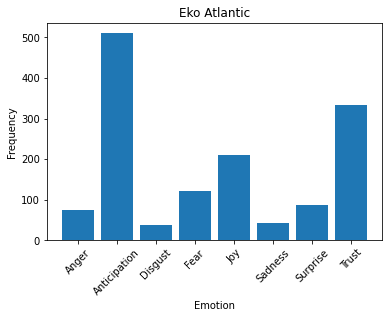

Processing Eko Atlantic_5.csv


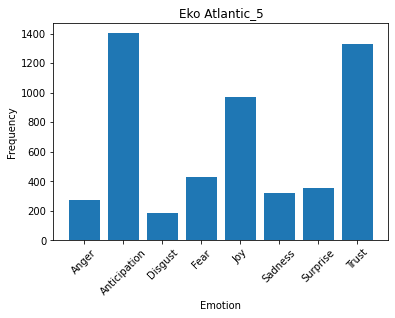

Processing Hope city.csv


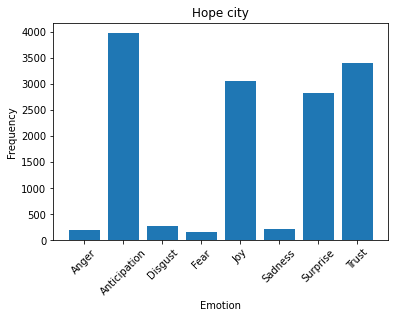

Processing Hope city_5.csv


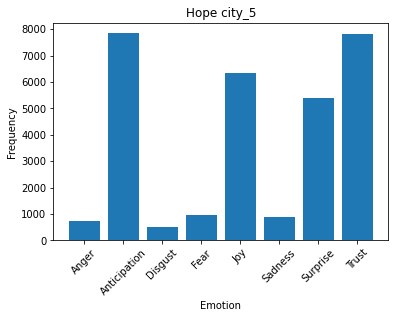

Processing Konza tech.csv


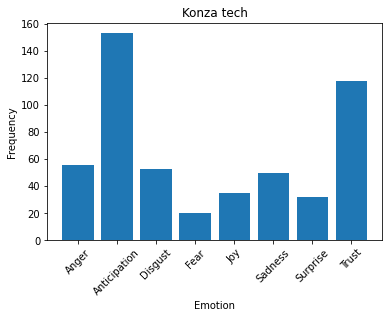

Processing Konza tech_5.csv


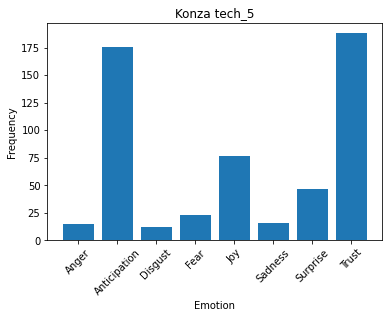

Processing Vision city.csv


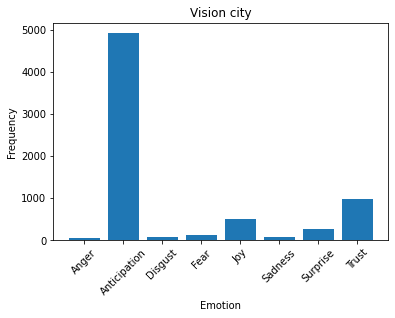

Processing Vision city_5.csv


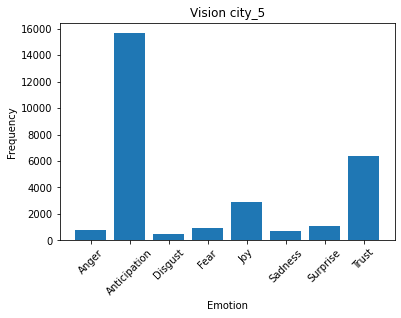

Processing Waterfall City.csv


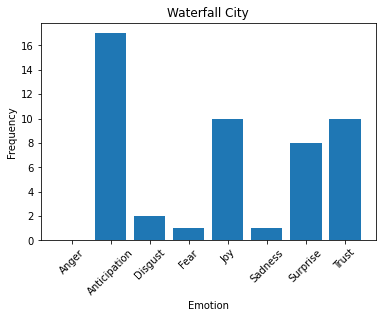

Processing Waterfall City_5.csv


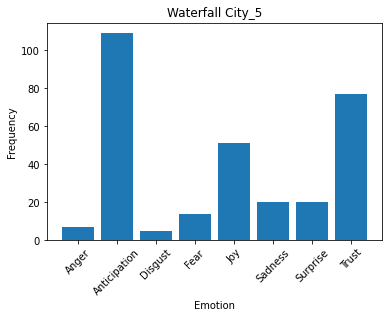

In [15]:
for file in os.listdir('tweets'):
    print("Processing", file)
    df = pd.read_csv(f'tweets/{file}', lineterminator='\n') #line terminator prevents parsing error
    df.rename(columns={'tweets\r': 'tweets'}, inplace=True)
    
    # Get VADER Compound value for sentiment intensity
    df['sentiment_intensity'] = [analyzer.polarity_scores(tweet)['compound'] for tweet in df['tweets']]
    
    # Using pandas apply/lambda to speed up the process
    df['sentiment'] = df.apply(lambda x: get_sentiment(x['sentiment_intensity']),axis=1)
    
    #print(2)
    # Join all the tweets in one single string
    joined_string = join_strings(df['tweets'])

    # Get tokens
    tokens = joined_string.split(' ')
    
    # We build now two dictionaries with indexes and unique words, for future reference
    unique_words = set(tokens)
    word_to_ind = dict((word, i) for i, word in enumerate(unique_words))
    ind_to_word = dict((i, word) for i, word in enumerate(unique_words))
    
    # We are using the NCR lexicon to associate words to emotions 
    # Be patient, this will take some time ...
    df, list_emotion_counts = get_tweet_emotions(df, emotions, 'tweets')
    
    # Get all rows where no emotion was detected and remove them
    all_zeros = []
    for i in range(len(df)):
        all_zeros.append(df.Anger[i] == df.Anticipation[i] == df.Disgust[i] == df.Fear[i] == df.Joy[i] == df.Sadness[i] == df.Surprise[i] == df.Trust[i] == 0)

    df["all_zeros"] = all_zeros

    # Get indexes where all_zeros column has value True
    indexNames = df[df['all_zeros'] == True].index # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['all_zeros'], inplace=True)
    
    # Get the counts for the various emotions (found in the last 8 columns)
    emo_counts = {}
    for emo in df.columns[-8:]:
        emo_counts[emo] = df[emo].sum()
        
    emotions = list(emo_counts.keys())
    counts = list(emo_counts.values())
    
    plt.bar(emotions, counts)
    plt.title(file[:-4])# give a title to the plot
    plt.xlabel("Emotion")
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    plt.show()

    # save newly edited df back to its file
    df.to_csv(f'tweets/{file}', index=False)

Processing Eko Atlantic.csv


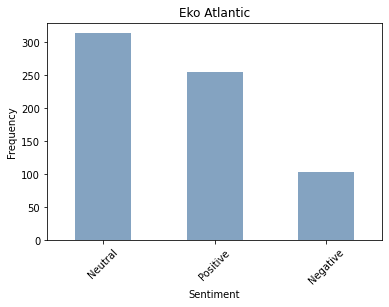

Processing Eko Atlantic_5.csv


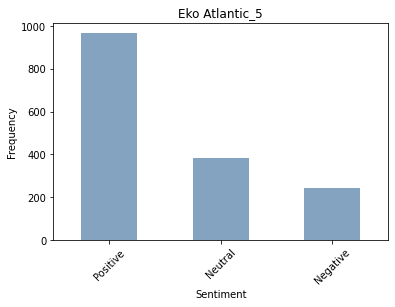

Processing Hope city.csv


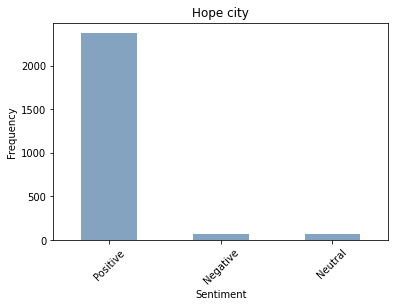

Processing Hope city_5.csv


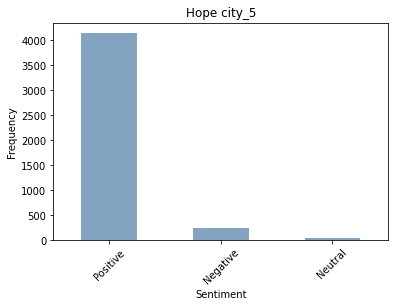

Processing Konza tech.csv


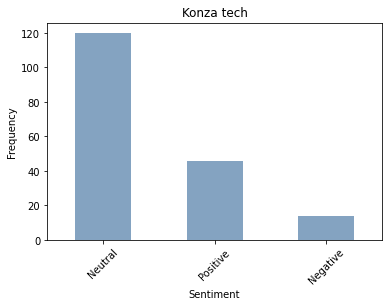

Processing Konza tech_5.csv


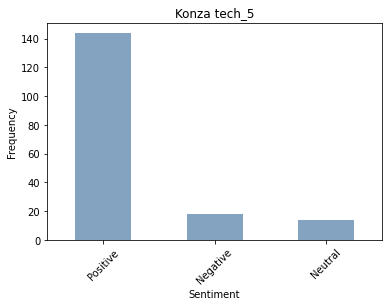

Processing Vision city.csv


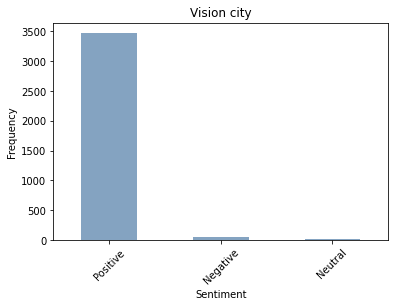

Processing Vision city_5.csv


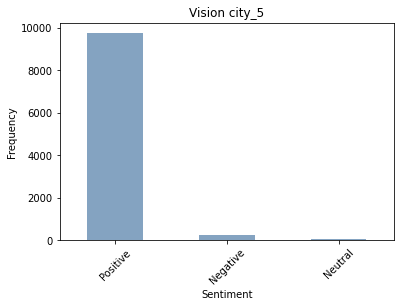

Processing Waterfall City.csv


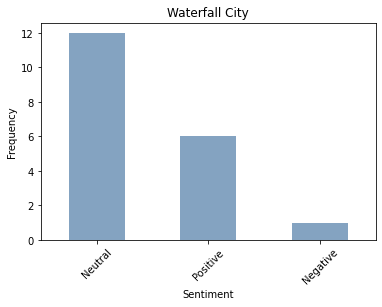

Processing Waterfall City_5.csv


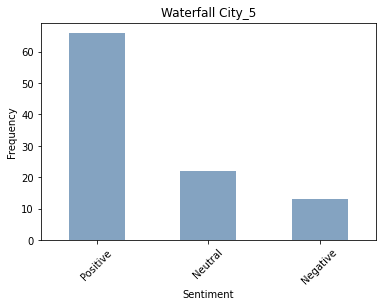

In [16]:
for file in os.listdir('tweets'):
    print("Processing", file)
    df = pd.read_csv(f'tweets/{file}', lineterminator='\n') #line terminator prevents parsing error
    
    df['sentiment'].value_counts().plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
    plt.title(file[:-4])# give a title to the plot
    plt.xlabel("Sentiment")
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    plt.show()